## Testing Julia for GAIA

using the julia language for GAIA analaysis <br>

1. Testing the optimization of the dbscan
2. Testng Affinity propagation ... not yet
3. Testing the metric


In [25]:
using PyCall
using DataFrames
using Statistics, Distributions

using Clustering
@pyimport scipy.spatial as sp

using Distances
using Random

push!(LOAD_PATH,"/home/stephane/Science/cluster/GAIA/master/src")
using GaiaClustering

import PyPlot; const plt = PyPlot

@pyimport astropy.io.votable as votable
# @pyimport matplotlib.pyplot as plt

## directory
rootdir = "/home/stephane/Science/cluster/GAIA"
wdir    = "/home/stephane/Science/cluster/GAIA/products"

cd(wdir)

In [26]:
## Main program

voname = "test.vot"

data       = read_votable(voname)
df         = filter_data(data)
dfcart     = add_cartesian(df)
blck       = [[1,2,3],[4,5], [6,7,8]]
wghtblck   = [4.0,5.0,1.0]
norm       = "identity"

dfcartnorm , scale8 = normalization_PerBlock(dfcart, blck, wghtblck , norm, false) 

## Votable test.vot read
## Filtering done ...
## Stars selected: 12531
## Cartesian transformation done ...
## Normalization identity done...
### [1pc,1pc,1pc,1km/s,1km/s,1mag,1mag] equivalent to [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037]
##


(GaiaClustering.Df(12531, [351.969 145.368 … 311.371 301.486; -10.9538 -4.46739 … 1.59019 1.33356; … ; 0.0727531 0.10941 … 0.0833555 0.134977; 0.0624644 0.119099 … 0.0617922 0.0464716], [81.0929 81.0461 … 76.1662 76.0495; -67.0953 -67.1114 … -68.4706 -68.4264; … ; 15.3938 16.2834 … 15.68 17.1638; 16.7528 18.5798 … 17.1387 18.9873], [0.0347643 0.0777114 … 0.0538083 0.208771; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), [0.398015, 0.398015, 0.398015, 0.497519, 0.497519, 0.0995037, 0.0995037, 0.0995037])

In [27]:
## Metric testing...
function _metricHRD(hrdi::GaiaClustering.Df , label)
    
    QA = []
    QP = []
    
    for ilab in label
        nhr = size(ilab)
        points = []
        
        for n in 1:nhr[1]
            push!(points,[hrdi.data[1,ilab[n]],hrdi.data[2,ilab[n]]])           
        end
    
        ## println("Voronoi tesselation ...")
        ## min_pts is the minimum of pts 
        if length(points) > 4
            per, area = voronoi(points)
        else
            per  = [1e10,1e10,1e10,1e10]
            area = [1e10,1e10,1e10,1e10]
        end
        
        p = sort(per ./ nhr[1])
        a = sort(area ./ nhr[1])
        
        n10 = max(1, trunc(Int, nhr[1] / 10))
        start10 = max(1 , 1*n10)
        end10   = min(nhr[1] , 9*n10)
        
        q1a  = mean(a[start10:end10])
        q1p  = mean(p[start10:end10])
        dq1a = std(a[start10:end10])
        dq1p = std(p[start10:end10])
        
        qa  = -log(max(1e-15, q1a))
        dqa = abs(dq1a/qa)   
        qp  = -log(max(1e-15, q1p)) 
        dqp = abs(dq1p / qp)
        
        push!(QA, (qa,dqa))
        push!(QP, (qp,dqp)) 
       
    end
    return(QA,QP)
end


##  proj :
##  spatial2d : y,z (id 2,3)
##  spatial3d : x,y,z (id 1,2,3)
##  velocity  : vrad,vdec (id 4,5)
##  HRD       : Diagram HR (id 6,7)
##
## labels : labels of the clusters##
##
## !!! works with dfcart !!! (cartesian and normalized)

## We add here a probability on the dispersion in space and velocity

function _metric(s::GaiaClustering.Df, labels ,proj = "spatial2d", APERTURE = 1.0 , 
        MAXAPERTURE = 15.0, NBOOTSTRAP = 50 , MAXDISP2D = 8.,  MAXDISP3D = 50. , MAXDISPVEL = 4.)

    ### probabilities of the dispersion..
    p2d  = Normal(0., MAXDISP2D)
    p3d  = Normal(0., MAXDISP3D)
    pvel = Normal(0., MAXDISPVEL)
    
    if proj == "spatial2d"
        ycenter = mean(s.data[2,:])
        zcenter = mean(s.data[3,:]) 
    elseif proj == "spatial3d"
        xcenter = mean(s.data[1,:])      
        ycenter = mean(s.data[2,:])
        zcenter = mean(s.data[3,:]) 
    elseif proj == "velocity"
        vxcenter = mean(s.data[4,:])      
        vycenter = mean(s.data[5,:])
    elseif proj == "HRD"
        res = _metricHRD(s, labels)
        return(res)
    end
    
    aper2 = APERTURE * APERTURE
    Q = []
    for ilab in labels
        slab = s.data[:,ilab]
            
        if proj == "spatial2d"
            yy = slab[2,:]
            zz = slab[3,:]
            ycenter = mean(yy)      
            zcenter = mean(zz)             
            angle_out = 2π * rand(Float64, NBOOTSTRAP)
            rad_out   = (MAXAPERTURE - 2APERTURE) * rand(Float64, NBOOTSTRAP)
            angle_in  = 2π * rand(Float64, NBOOTSTRAP)
            rad_in    = APERTURE * randexp(Float64, NBOOTSTRAP)
            ydisp = std(slab[2,:])
            zdisp = std(slab[3,:])
            prob2d = pdf(p2d,sqrt(ydisp^2+zdisp^2)) / pdf(p2d,0.)
            println("## disp $(sqrt(ydisp^2+zdisp^2))")
            println("## prob2d $prob2d")
        elseif proj == "spatial3d"
            xx = slab[1,:]
            yy = slab[2,:]
            zz = slab[3,:]
            xcenter = mean(xx)             
            ycenter = mean(yy)      
            zcenter = mean(zz)             
            angle_out = 2π * rand(Float64, NBOOTSTRAP)
            phi_out   = π * rand(Float64, NBOOTSTRAP)
            rad_out   = (MAXAPERTURE - 2APERTURE) * rand(Float64, NBOOTSTRAP)
            angle_in  = 2π * rand(Float64, NBOOTSTRAP)
            phi_in    = π * rand(Float64, NBOOTSTRAP)           
            rad_in    = APERTURE * randexp(Float64, NBOOTSTRAP)
            xdisp = std(slab[1,:])
            ydisp = std(slab[2,:])
            zdisp = std(slab[3,:])
            prob3d = pdf(p3d,sqrt(xdisp^2+ydisp^2+zdisp^2)) / pdf(p3d,0.)
            println("## prob3d $prob3d")
        elseif proj == "velocity"
            vx = slab[4,:]
            vy = slab[5,:]   
            vxcenter = mean(vx)      
            vycenter = mean(vy) 
            angle_out = 2π * rand(Float64, NBOOTSTRAP)
            rad_out   = (MAXAPERTURE - 2APERTURE) * rand(Float64, NBOOTSTRAP)
            angle_in  = 2π * rand(Float64, NBOOTSTRAP)
            rad_in    = APERTURE * rand(Float64, NBOOTSTRAP)  
            vxdisp = std(slab[4,:])
            vydisp = std(slab[5,:])
            probvel = pdf(pvel,sqrt(vxdisp^2+vydisp^2)) / pdf(pvel,0.)
            println("## probvel $probvel")
        end  
        
        qc = zeros(NBOOTSTRAP)
            
        for k in 1:NBOOTSTRAP
            if proj == "spatial2d"
                prob =  prob2d
                yout = ycenter + rad_out[k] * cos(angle_out[k])
                zout = zcenter + rad_out[k] * sin(angle_out[k])
                radii_out = (slab[2,:] .- yout) .* (slab[2,:] .- yout) .+ (slab[3,:] .- zout) .* (slab[3,:] .- zout)
                yin = ycenter + rad_in[k] * cos(angle_in[k])
                zin = zcenter + rad_in[k] * sin(angle_in[k])
                radii_in = (slab[2,:] .- yin) .* (slab[2,:] .- yin) .+ (slab[3,:] .- zin) .* (slab[3,:] .- zin)                
            elseif proj == "spatial3d"
                prob = prob3d
                xout = xcenter + rad_out[k] * cos(angle_out[k]) *  cos(phi_out[k])         
                yout = ycenter + rad_out[k] * sin(angle_out[k]) *  cos(phi_out[k])  
                zout = zcenter + rad_out[k] * sin(phi_out[k])
                radii_out = (slab[1,:] .- xout) .* (slab[1,:] .- xout) .+ (slab[2,:] .- yout) .* (slab[2,:] .- yout).+ (slab[3,:] .- zout) .* (slab[3,:] .- zout)
                xin = xcenter + rad_in[k] * cos(angle_in[k]) *  cos(phi_in[k])                  
                yin = ycenter + rad_in[k] * sin(angle_in[k]) *  cos(phi_in[k]) 
                zin = zcenter + rad_in[k] * sin(phi_in[k])
                radii_in = (slab[1,:] .- xin) .* (slab[1,:] .- xin) .+ (slab[2,:] .- yin) .* (slab[2,:] .- yin).+ (slab[3,:] .- zin) .* (slab[3,:] .- zin)              
            elseif proj == "velocity"
                prob = probvel
                vxout = vxcenter + rad_out[k] * cos(angle_out[k])
                vyout = vycenter + rad_out[k] * sin(angle_out[k])
                radii_out = (slab[4,:] .- vxout) .* (slab[4,:] .- vxout) .+ (slab[5,:] .- vyout) .* (slab[5,:] .- vyout)
                vxin = vxcenter + rad_in[k] * cos(angle_in[k])
                vyin = vycenter + rad_in[k] * sin(angle_in[k])
                radii_in = (slab[4,:] .- vxin) .* (slab[4,:] .- vxin) .+ (slab[5,:] .- vyin) .* (slab[5,:] .- vyin)                
            end
            
            isdout = radii_out .< aper2
            nout   = length(radii_out[isdout])
            isin   = radii_in .< aper2 
            nin    = length(radii_in[isin])
         
            qc[k] = prob * (log(max(1,nin)) - log(max(1,nout)))
                
        end
            
        Qc    = mean(qc)
        Q_std = std(qc)    
        #println("Q: $Qc -- Q_std : $Q_std")
        push!(Q,(Qc,Q_std))  
    end
    return(Q)
end

_metric (generic function with 8 methods)

In [28]:
## Clustering ..
println("## Starting Clustering ...")

###########################3
eps = 3.0
min_nei = 5
min_cl = 15

println("ϵ : $eps")

dftemp = copy1(dfcartnorm)
println("## dbscan..")
labels = clusters(dftemp.data , eps , 20, min_nei, min_cl)
println("### done ...")



println("## Computing metric ...")
# println(labels)
println("spatial2d")
q2d = _metric(dfcart, labels, "spatial2d" , 1.0 , 20.0, 20 )
#println(q2d)
println("spatial3d")
q3d = _metric(dfcart, labels, "spatial3d" , 1.0 , 10.0, 20 )
#println(q3d)
println("velocity")
qv = _metric(dfcart, labels, "velocity" , 5.0 , 30.0, 20 )
#println(qv)
println("HRD")
qp, qa = _metric(dfcart, labels, "HRD" )
println(q2d)
println(q3d)
println(qv)
println(qp)
println(qa)


npts = []
nlab = 0
for ilab in labels
    nlab += 1
    println("Label:",nlab," - :",length(ilab))
    push!(npts, length(ilab))
end

indx = labels[1]

## Starting Clustering ...
ϵ : 3.0
## dbscan..
### done ...
## Computing metric ...
spatial2d
## disp 6.233311801466149
## prob2d 0.7381942703165032
## disp 2.6491124672260065
## prob2d 0.9466493414003777
## disp 3.0506957291511214
## prob2d 0.9298714382105701
## disp 3.750031688212806
## prob2d 0.8959549574364547
spatial3d
## prob3d 0.9618615140291532
## prob3d 0.9945199076483315
## prob3d 0.9789468527935216
## prob3d 0.9883921840130916
velocity
## probvel 0.9114502132615087
## probvel 0.4162246276364082
## probvel 0.46578360219409426
## probvel 0.6392462572723265
HRD
Any[(0.667187, 0.703597), (0.24885, 0.467278), (0.409741, 0.758942), (0.0720992, 0.322437)]
Any[(-0.0333356, 0.149081), (0.103402, 0.252541), (0.0339277, 0.151729), (0.0, 0.0)]
Any[(3.33408, 1.73837), (0.720226, 0.447997), (1.06117, 0.71183), (1.1624, 0.655086)]
Any[(2.78592, 0.0181804), (1.44737, 0.170803), (2.5305, 0.0221723), (2.46373, 0.0692349)]
Any[(2.43424, 0.0158917), (0.834301, 0.477998), (1.89753, 0.0429508), (

130-element Array{Int64,1}:
    57
   552
  1008
  1082
  1442
  1776
  1960
  1993
  1998
  2112
  2227
  2269
  2300
     ⋮
  5944
  6392
  6840
  7084
  7247
  7701
  8659
  9767
  9899
 10620
 11328
 11485

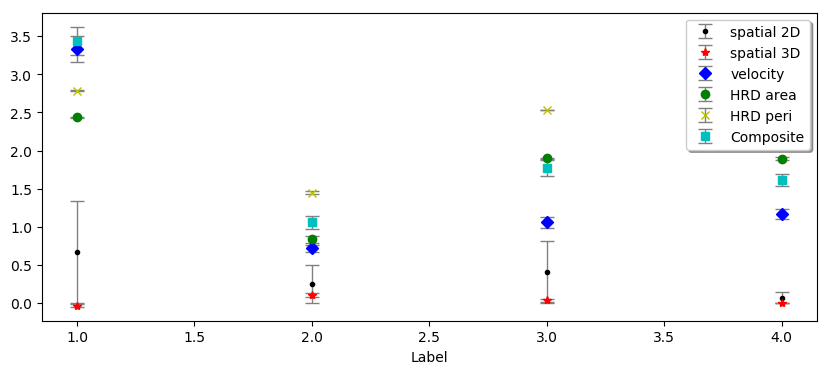

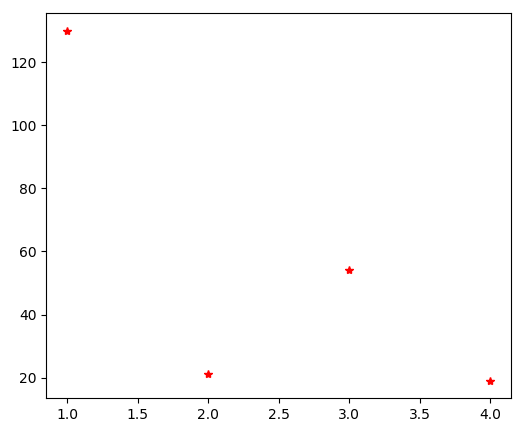

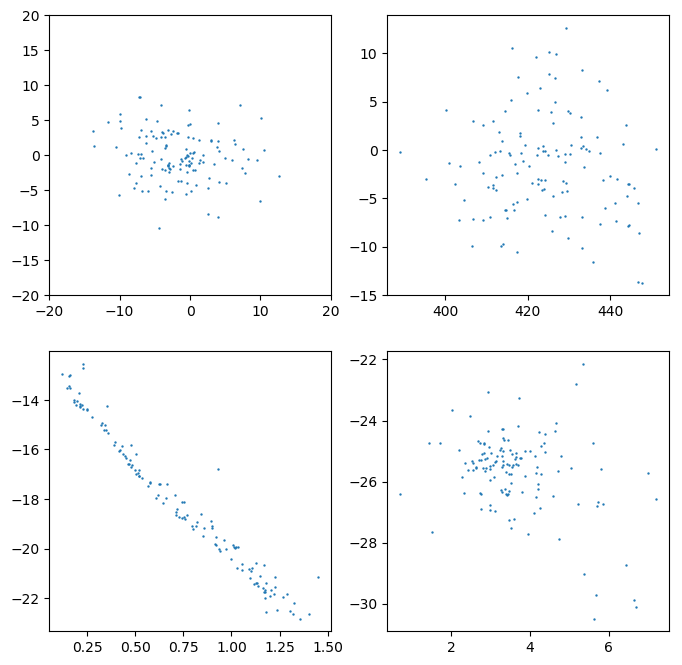

In [29]:
## push Q, Q_st
function pushQ(qc)
    q1  = []
    q1d = []
    for q in qc
        push!(q1,q[1])
        push!(q1d,q[2]/10) 
    end
    return(q1, q1d)
end
    
## metric of the labels
plt.figure(figsize=(10.0,4.0))

xlabel = 1:nlab

qq2d  , qqd2d = pushQ(q2d)
qq3d  , qqd3d = pushQ(q3d)
qqv  , qqdv = pushQ(qv)
qqa  , qqda = pushQ(qa)
qqp  , qqdp = pushQ(qp)


## composite
Qcp = (3.0 .* qq2d .+ qq3d .+ 3.0 .* qqv .+ qqa .+ qqp) ./ 5
Qdcp = (3.0 .* qqd2d .+ qqd3d .+ 4.0 .* qqdv .+ qqda .+ qqdp) ./ 5 


plt.errorbar(xlabel, qq2d, qq2d, label="spatial 2D",fmt=".k", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qq3d, qqd3d, label="spatial 3D",fmt="*r", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqv, qqdv, label="velocity",fmt="Db", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqa, qqda, label="HRD area",fmt="og", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, qqp, qqdp, label="HRD peri",fmt="xy", ecolor="gray", lw=1, capsize=5)
plt.errorbar(xlabel, Qcp, Qdcp, label="Composite",fmt="sc", ecolor="gray", lw=1, capsize=5)
plt.legend(loc="upper right", shadow=true)
plt.xlabel("Label")
plt.show()

plt.figure(figsize=(6.0,5.0))
plt.plot(xlabel, npts,"*r")
plt.show()


plt.figure(figsize=(8.0,8.0))

plt.subplot(2, 2, 1 , xlim = [-20,20] , ylim = [-20,20])
x = dfcart.data[2,indx]
y = dfcart.data[3,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 2)
x = dfcart.data[1,indx]
y = dfcart.data[2,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 3)
x = dfcart.data[7,indx]
y = -dfcart.data[6,indx]
plt.scatter(x, y , s = 0.5 )

plt.subplot(2, 2, 4)
x = dfcart.data[4,indx]
y = -dfcart.data[5,indx]
plt.scatter(x, y , s = 0.5 )


plt.show()